In [1]:
# Imports
import os.path
import numpy as np
from numpy import fft
import scipy.ndimage as ndi
import skimage as ski
from skimage import io
from skimage import feature
from skimage import filters
from skimage import color
from skimage import segmentation
from sklearn import cluster # scikit-learn: a machine learning library
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2

# Pull from ImageProcessing Repo
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

from ImageProcessingF2021.video import run_video

mpl.rcParams['figure.figsize'] = (10,10)
plt.gray();

Already up to date.


<Figure size 720x720 with 0 Axes>

In [2]:
def equalizeHistogram(im, clahe=None):
    """
    This applies histogram qualization to the luminance of the given color image (which must be
    grayscale or RGB). The luminance is essentially the grayscale of the image, but this applies
    it to that and then adjusts the color image to match that luminance.

    If this is provided with a CLAHE object, it is used to perform the CLAHE instead of global
    histogram equalization.
    """
    if im.ndim == 3 and im.shape[2] >= 3:
        ycrcb = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)   # or color.rgb2ycbcr(im)
        if clahe is not None:
            ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
        else:
            ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])  # or exposure.equalize_hist(im)
        im = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)   # or color.ycbcr2rgb(im)
    else:  # assume grayscale
        im = cv2.equalizeHist(im) if clahe is None else clahe.apply(im)
    return im

In [3]:
# Ranges used by image_in_range function
lower1 = np.array([0, 39, 31], np.uint8)
upper1 = np.array([50, 255, 255], np.uint8)

lower2 = np.array([65, 98, 0], np.uint8)
upper2 = np.array([179, 255, 255], np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(21,21))

def image_in_range(im, colorized=True):
    """
    Returns a binary image where Trues (actually 255) in the result are when the HSV version is in the
    range of the global variables lower and upper.

    If colorized is True then the returned image has the pixels set to the color of the original image
    wherever the binary image is True.
    """
    he = equalizeHistogram(im, clahe)
    hsvim = cv2.cvtColor(he, cv2.COLOR_RGB2HSV)    # or color.rgb2hsv(im)
    mask = (cv2.inRange(hsvim, lower1, upper1) > 0) | (cv2.inRange(hsvim, lower2, upper2) > 0)  # or ((lower1 <= im).all(2) & (im <= upper1).all(2)) | ((lower2 <= im).all(2) & (im <= upper2).all(2))
    return color_mask(im, mask) if colorized else mask

def color_mask(im, mask):
    """
    Takes a color image and a mask and returns a new image that is black outside the mask but colored
    in the mask.
    """
    return mask[:, :, None] * im

In [4]:
def get_outline(im):
    """
    Takes an image, segments and finds its edges then goes through processes of dilating to create
    a detailed outlined binary version.
    """
    im = im[: ,70:-70]
    seg = image_in_range(im)
    edges = feature.canny(color.rgb2gray(seg))
    edges = ndi.binary_dilation(edges)
    dilated = ndi.binary_opening(ndi.binary_closing(ndi.binary_opening((edges))))
    try: 
        # Find the largest contour's highest and lowest points
        contours, _ = cv2.findContours(dilated.view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=lambda x: cv2.contourArea(x))
        largest_contour = largest_contour.squeeze() # removes the random "1" dimension in the middle
        max_x, max_y = max(largest_contour[:,1]), max(largest_contour[:,0])
        min_x, min_y = min(largest_contour[:,1]), min(largest_contour[:,0])
        # slice the image to the dimensions of the contour and resize
        dilated = dilated[min_x:max_x, min_y:max_y]
        return cv2.resize(dilated.astype('float'), (150,150))
    #if there is no contour to be found, catch the exception and return the original image
    except:
        return im

In [5]:
im = run_video( camera_num=1, return_orig=True)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01h\x08\x02\x00\x00\x00HP\xdd\x06\x…

In [37]:
im = run_video(get_outline, camera_num=1, return_orig=True)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x96\x00\x00\x00\x96\x08\x00\x00\x00\x00\x19j.>\x…

In [6]:
# Code to save every frame
i = 0
def saver(im):
    """
    Saves every 4th frame for 80 frames (20 images)
    """
    global i
    while i < 80:
        outlined = get_outline(im[20:-20, 20:-30])
        if i % 4 == 0:
            num=i//4
            io.imsave(f'alphabet/test_images/c{num}.png', outlined)
        i += 1
        return outlined
    return im

In [7]:
def hand_feature_vectors(im):
    """
    This is a very simple feature vector set: just the pixel values in their original order
    (after forcing the image size to be 150x150).
    """
    return cv2.resize(im.astype('float'), (150, 150)).ravel()

def extract_training_hands(im, fv=hand_feature_vectors):
    """
    Extracts the training hands from the given image. The image must have 3 rows with
    each row a different letter but the same height. The hands must be square. Every
    hand image is sent to the given feature vector function which must return a 1D
    set of values that are the features for that image. The same function will later be
    used to make the feature vectors for the hands being identified.
    
    This returns two arrays:
        feature_vectors: NxM where N is # examples and M is # features for each example
        labels:          Nx1
    """
    feature_vectors = []
    labels = []
    src_height = im.shape[0] // 3 #26 for full alphabet
    src_width = im.shape[1] // 20 #20 is the number of original samples per letter

    # height 150
    # width 150

    count = im.shape[1] // src_width
    for hand in range(3):
        row = im[hand*src_height:(hand+1)*src_width]
        for i in range(count):
            single_hand = row[:, i*src_width:(i+1)*src_width]
            feature_vectors.append(fv(single_hand))
            labels.append(hand)
            # Stretch Vertically
            feature_vectors.append(fv(single_hand[1:-1]))
            labels.append(hand)

            # Stretch Horizontally
            feature_vectors.append(fv(single_hand[:, 1:-1]))
            labels.append(hand)

            # Pad
            feature_vectors.append(fv(np.pad(single_hand, 2)))
            labels.append(hand)

            # Rotate
            feature_vectors.append(fv(ndi.rotate(single_hand, 15)))
            labels.append(hand)

    return np.array(feature_vectors, dtype=np.float32), np.array(labels).reshape(-1, 1)

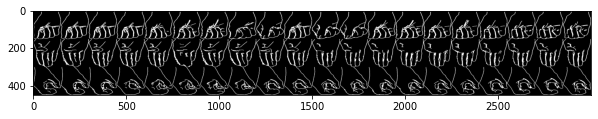

In [8]:
alphabet_im = io.imread('LabelsPage.png')[:, :, 0]
plt.imshow(alphabet_im)

In [9]:
fv, lbls = extract_training_hands(alphabet_im)

In [10]:
for shift in ((0,0), (1,1), (-1,-1), (1,0), (0,1), (-1,0), (0,-1), 
                (2,2), (-2,-2), (0,2), (2,0), (-2,0), (0,-2),
                (3,3), (-3,-3), (0,3), (3,0), (-3,0), (0,-3)):
    shifted = ndi.shift(alphabet_im, shift)

    # Extract the feature vectors and labels for the hands
    fv, lbls = extract_training_hands(shifted)
    feature_vectors = [fv]
    labels = [lbls]

    # Dilate training data
    fv, lbls = extract_training_hands(ndi.grey_dilation(alphabet_im, 3))
    feature_vectors.append(fv)
    labels.append(lbls)

    # Erode training data
    fv, lbls = extract_training_hands(ndi.grey_erosion(alphabet_im, 3))
    feature_vectors.append(fv)
    labels.append(lbls)

    feature_vectors = np.concatenate(feature_vectors)
    labels = np.concatenate(labels)

# TAKES ABOUT 22 SECONDS for all transformations on training data


In [11]:
# Create and train the classifier
knn = cv2.ml.KNearest_create()
knn.train(fv, cv2.ml.ROW_SAMPLE, lbls)

True

In [13]:
# Testing classifier on test image set (not images trained on)
_, letters, _, scores = knn.findNearest(hand_feature_vectors(io.imread('alphabet/test_images/a1.png')).astype(dtype=np.float32)[None, :], k=4)
print(letters, scores)

[[0.]] [[1.5784870e+08 1.5801251e+08 1.5964469e+08 1.6191202e+08]]


In [30]:
def asl_translator(im):
    """
    Putting it all together, this function gets the outline/resizes the hand image from the camera,
    Turns it into a feature vector, and then runs the KNearest classifier on it. 
    The letter selected is written on the bottom right of the image and the scores along the top 

    Returns: the outlined hand image with the letter in the bottom right
    """

    segmented = image_in_range(im, True)
    contours,_ = cv2.findContours(color.rgb2gray(segmented).view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=lambda x: cv2.contourArea(x)).squeeze()
    if cv2.contourArea(contour) < 100000: return im 

# 0.9 * (im.shape[0] * im.shape[1])
    letters = 'ABC'
    outlined = get_outline(im)
    _, letter_index, _, scores = knn.findNearest(hand_feature_vectors(outlined).astype(dtype=np.float32)[None, :]*255, k=4)
    letter = letters[int(letter_index.squeeze())]
    cv2.putText(outlined, letter, (120, 140), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0))
    cv2.putText(outlined, str(scores), (10, 10), cv2.FONT_HERSHEY_PLAIN, 0.5, (255, 0, 0))
    return outlined

In [32]:
im = run_video(asl_translator, camera_num=1, return_orig=True)

203831.5


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x96\x00\x00\x00\x96\x08\x00\x00\x00\x00\x19j.>\x…

222628.0
209963.5
210719.0
211811.0
200409.5
180457.0
176476.5
172496.0
170694.0
171979.0
177554.5
179611.5
173842.0
185240.0
196283.5
